# Parallel computations: dask

In [1]:
import pandas as pd
import numpy as np

import glob

allfiles_trade=glob.glob("data/raw/TRTH/equities/US/2010/trade/AAPL.OQ/*")
allfiles_bbo=glob.glob("data/raw/TRTH/equities/US/2010/bbo/AAPL.OQ/*")

In [2]:
allfiles_trade=np.sort(allfiles_trade)[:100]
allfiles_bbo=np.sort(allfiles_bbo[:100])

### Dask in practice

In [3]:
import dask
dask.config.set(scheduler="processes")

@dask.delayed
def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
   
    try:
        DF = pd.read_csv(filename)
    except:
        return None
    
    if DF.shape[0] ==0:
        return None
    
    
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF


@dask.delayed
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
        
    try:
        DF = pd.read_csv(filename)
    except:
        return None
    
    if DF.shape[0] ==0:
        return None
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [4]:
allpromises_trade=[load_TRTH_trade(fn) for fn in allfiles_trade]    # this takes not time at all
allpromises_bbo=[load_TRTH_bbo(fn) for fn in allfiles_bbo]

In [5]:
alltrades=dask.compute(allpromises_trade)[0]                 # now the computations take place. Monitor your CPU !
allbbos=dask.compute(allpromises_bbo)[0]                 # now the computations take place. Monitor your CPU !

In [6]:
alltrades=pd.concat(alltrades)
allbbos=pd.concat(allbbos)

In [7]:
allevents=alltrades.join(allbbos,how='inner')

In [170]:
allevents.ffill(inplace=True)
allevents

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume
xltime,,,,,,
2010-01-04 09:30:00.000979200-05:00,NaN,NaN,213.27,1.0,213.41,1.0
2010-01-04 09:30:00.000979200-05:00,NaN,NaN,213.27,1.0,213.42,1.0
2010-01-04 09:30:00.000979200-05:00,NaN,NaN,213.29,1.0,213.42,1.0
2010-01-04 09:30:00.000979200-05:00,NaN,NaN,213.29,1.0,213.42,2.0
2010-01-04 09:30:00.000979200-05:00,NaN,NaN,213.29,1.0,213.42,1.0
...,...,...,...,...,...,...
2010-12-31 15:59:59.733974400-05:00,237.57,800.0,322.48,24.0,322.49,26.0
2010-12-31 15:59:59.787024-05:00,237.57,800.0,322.48,24.0,322.49,16.0
2010-12-31 15:59:59.799033600-05:00,237.57,800.0,322.48,24.0,322.49,10.0


In [120]:
import time

t0=time.time()
allevents.to_csv('allevents.csv.gz')
t1=time.time()
t1-t0

534.3092017173767

In [9]:
import time
t0=time.time()
allevents.to_parquet("allevents.parquet",allow_truncated_timestamps=True)
t1=time.time()
t1-t0

0.6316018104553223

In [25]:
import pyarrow as pa   # penalty to convert the DataFrame to arrow RAM representation 
t0=time.time()
pa.Table.from_pandas(allevents)
t1=time.time()
t1-t0

0.04172182083129883

In [174]:

alltrades["5min"]=(alltrades.index.hour*60+alltrades.index.minute)//5
numtrades_5min=alltrades["5min"].value_counts()

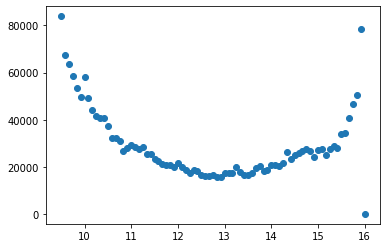

In [176]:
import matplotlib.pyplot as plt
plt.scatter(numtrades_5min.index*5/60,numtrades_5min.values)

In [10]:
allevents["s"]=2*((allevents["ask-price"]-allevents["trade_price"])>(allevents["trade_price"]-allevents["bid-price"]))-1

In [23]:
# s is too long for the usual auto-correlation functions (complexity O(N^2)). 
# One should use Fast Fourier Transforms instead
# source: https://dsp.stackexchange.com/questions/54924/autocorrelation-numpy-versus-fft
# exercise: show that the auto-correlation can be obtained from the power spectrum

s = allevents["s"].values
s = np.concatenate((s,np.zeros(len(s)-1))) # added zeros to your signal
A = np.fft.fft(s)
S = np.conj(A)*A
c_fourier = np.fft.ifft(S)
c_fast = c_fourier[:(c_fourier.size//2)+1]/len(s)

/home/damien/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


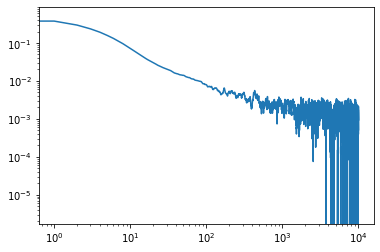

In [24]:
import matplotlib.pyplot as plt
plt.plot(c_fast[:10000,])
plt.xscale("log")
plt.yscale("log")